In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Splitting 80% for training and 20% for validation
)

Test_path = '/content/drive/My Drive/DataSet_Work/Anaconda1/Train'
Val_path = '/content/drive/My Drive/DataSet_Work/Anaconda1/Valid'

train_generator = train_datagen.flow_from_directory(
    Test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Since it's a binary classification task
    subset='training'  # Specify this is the training set
)

validation_generator = train_datagen.flow_from_directory(
    Val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify this is the validation set
)

Found 2412 images belonging to 2 classes.
Found 211 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout

def MobileNetV2_model(learning_rate, input_shape, class_number):
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))

    # Freeze layers except the last few <----------------------------------------
    for layer in baseModel.layers[:-4]:
        layer.trainable = False

    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(class_number, activation='softmax'))

    return model

# Example usage:
input_shape = (224, 224, 3)  # Adjust according to your image dimensions
class_number = 2  # Two classes: ham and spam
learning_rate = 0.001  # Adjust as needed

model = MobileNetV2_model(learning_rate, input_shape, class_number)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 average_pooling2d (Average  (None, 3, 3, 1280)        0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                           

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=200,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/200
76/76 [==============================] - 598s 7s/step - loss: 0.5166 - accuracy: 0.9158 - val_loss: 0.2884 - val_accuracy: 0.9427
Epoch 2/200
76/76 [==============================] - 163s 2s/step - loss: 0.1547 - accuracy: 0.9672 - val_loss: 0.3816 - val_accuracy: 0.8490
Epoch 3/200
76/76 [==============================] - 182s 2s/step - loss: 0.0819 - accuracy: 0.9826 - val_loss: 1.6100 - val_accuracy: 0.7917
Epoch 4/200
76/76 [==============================] - 155s 2s/step - loss: 0.0498 - accuracy: 0.9859 - val_loss: 0.7675 - val_accuracy: 0.8594
Epoch 5/200
76/76 [==============================] - 167s 2s/step - loss: 0.0439 - accuracy: 0.9905 - val_loss: 1.1780 - val_accuracy: 0.8646
Epoch 6/200
76/76 [==============================] - 156s 2s/step - loss: 0.0180 - accuracy: 0.9946 - val_loss: 1.1089 - val_accuracy: 0.8750
Epoch 7/200
76/76 [==============================] - 164s 2s/step - loss: 0.0107 - accuracy: 0.9963 - val_loss: 0.8736 - val_accuracy: 0.8958
Epoch 

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy:.3f}')

7/7 [==============================] - 14s 2s/step - loss: 3.7802 - accuracy: 0.8910
Validation accuracy: 0.891


Found 700 images belonging to 2 classes.
22/22 [==============================] - 137s 6s/step
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       260
           1       0.99      0.93      0.96       440

    accuracy                           0.95       700
   macro avg       0.94      0.96      0.95       700
weighted avg       0.95      0.95      0.95       700



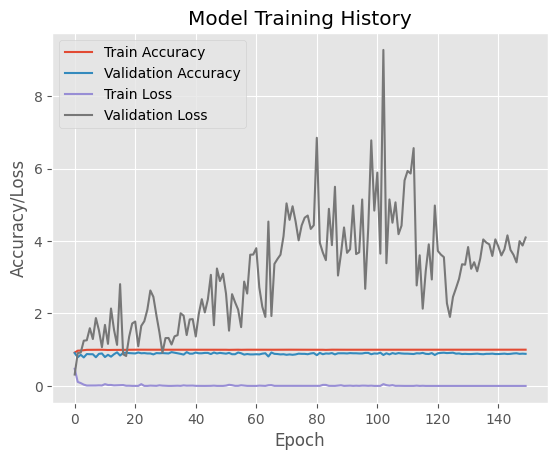

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Set ggplot style
matplotlib.style.use('ggplot')

# Assuming test data is in 'test_dir' directory
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/DataSet_Work/Anaconda1/Test',  # Replace with your test directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Adjust based on your problem
    shuffle=False
)

# Get the number of samples in the test set
num_samples = test_generator.samples

# Predict on the test data directly using the generator
y_pred = model.predict(test_generator)

# Convert predictions to binary class labels (adjust threshold if needed)
pred = np.argmax(y_pred, axis=1)  # Select class with highest probability

# Get true labels from the generator
y_test = test_generator.classes

# Print classification report
print(classification_report(y_test, pred))

# Plot training history
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.savefig('training_history.png')
plt.show()